In [1]:
from tqdm import tqdm_notebook
from tqdm import tqdm

import json
import pandas as pd

from utils.openai_utils import LLMTripletExtractor
from utils.dynamic_index_utils import Aligner

import os
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

/home/jovyan/chepurova/Text2KG/venv/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open("hotpotqa200.json", "r") as f:
    ds = json.load(f)

In [3]:
def compute_f1(prediction, truth):
    pred_tokens = prediction.split()
    truth_tokens = truth.split()
    
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    
    return 2 * (prec * rec) / (prec + rec)

## How many answers are in the reference texts?

In [4]:
sum([elem['answer'] in " ".join([" ".join(sent[1]) for sent in elem['context']]) for elem in ds]) / len(ds)

0.99

In [5]:
context_contains_ans = 0
samples = 0
for sample in ds:
    ans = sample['answer']

    if ans != 'no' and ans != 'yes':
        samples += 1
        # sample['context] - list of lists [TITLE, [TEXTS]]
        context = " ".join([" ".join(context[1]) for context in sample['context']])
        context_contains_ans += ans in context

context_contains_ans / samples

1.0

## How many answers in the constructed KG??

In [10]:
import string
def normalize(input_string):
    input_string = input_string.lower()
    translator = str.maketrans('', '', string.punctuation)
    return input_string.translate(translator)

In [11]:
contain_ans = 0
file_cnt = 0

wrong_ans_types = []
types = []

for file in os.listdir('hotpot200_res'):
    df = pd.read_csv('hotpot200_res/{}'.format(file), index_col=0)
    idx = int(file.split('.')[0])
    ans = normalize(ds[idx]['answer'])

    df['subject'] = df['subject'].apply(lambda x: normalize(x))
    df['object'] = df['object'].apply(lambda x: normalize(x))

    if ans == "yes" or ans == "no":
        continue
    types.append(ds[idx]['type'])
    
    if len(df[(df['subject'] == ans) | (df['object'] == ans)]) > 0:
        contain_ans += 1
    else:
        wrong_ans_types.append(ds[idx]['type'])
        print(ans)
    file_cnt += 1

contain_ans / file_cnt

fortnightly women interest magazine
a failed coup attempt
2 march 1972
pulitzer prize
hawaii county
german
superregional shopping mall
1978
london
chronological collection of critical quotations
22 november
1927
read it and weep 2006
velvetpark
papa ginos
shukratara
captain hans geering
frederick alexander


0.6170212765957447

In [12]:
Counter(wrong_ans_types), Counter(types)

(Counter({'comparison': 3, 'bridge': 15}),
 Counter({'bridge': 41, 'comparison': 6}))

In [36]:
contain_ans = 0
file_cnt = 0
f1s = []

contain_ans_entity = []
not_contain_ans_entity = []

wrong_ans_types = []
types = []

for file in os.listdir('hotpot200_res'):
    df = pd.read_csv('hotpot200_res/{}'.format(file), index_col=0)
    idx = int(file.split('.')[0])

    df['subject'] = df['subject'].apply(lambda x: normalize(x))
    df['object'] = df['object'].apply(lambda x: normalize(x))

    ans = normalize(ds[idx]['answer'])
    subj_obj = list(df['subject']) + list(df['object'])


    types.append(ds[idx]['type'])

    if ans == "yes" or ans == "no":
        continue

    if any([ans in elem for elem in subj_obj]) or any([elem in ans for elem in subj_obj]):
        for elem in subj_obj:
            if ans in elem or elem in ans:
                contain_ans_entity.append((ans, elem))
                break
        contain_ans += 1
       
    else:
        wrong_ans_types.append(ds[idx]['type'])
        not_contain_ans_entity.append((ans, max_f1_entity))

    max_f1 = 0
    max_f1_entity = ''

    for elem in subj_obj:
        f1 = compute_f1(elem, ans)
        if f1 > max_f1:
            max_f1 = f1
            max_f1_entity = elem
    f1s.append(max_f1)
  
    file_cnt += 1

contain_ans / file_cnt, sum(f1s)/len(f1s)

(0.8936170212765957, 0.7745862884160757)

In [14]:
for ans, entity in contain_ans_entity:
    print(f"Entity <{entity}> contains answer <{ans}>")

Entity <gesellschaft mit beschränkter haftung> contains answer <gesellschaft mit beschränkter haftung>
Entity <jonny craig> contains answer <jonny craig>
Entity <maine> contains answer <bath maine>
Entity <creature comforts> contains answer <creature comforts>
Entity <women> contains answer <fortnightly women interest magazine>
Entity <2004> contains answer <2004>
Entity <love and theft> contains answer <love and theft>
Entity <9> contains answer <2 march 1972>
Entity <tybalt> contains answer <tybalt>
Entity <virginia> contains answer <virginia>
Entity <engineering> contains answer <engineering>
Entity <teen titans go> contains answer <teen titans go>
Entity <oklahoma sooners> contains answer <oklahoma sooners>
Entity <2011 pulitzer prize in general nonfiction> contains answer <pulitzer prize>
Entity <1988> contains answer <1988>
Entity <mayor of hawaii county> contains answer <hawaii county>
Entity <sam boyd stadium> contains answer <sam boyd stadium>
Entity <1941> contains answer <19

In [15]:
for ans, entity in not_contain_ans_entity:
    print("Doesn't contain", ans, "The most similar entity is ", entity)

Doesn't contain a failed coup attempt The most similar entity is  
Doesn't contain german The most similar entity is  
Doesn't contain london The most similar entity is  
Doesn't contain chronological collection of critical quotations The most similar entity is  bard of avon
Doesn't contain captain hans geering The most similar entity is  captain alberto bertorelli


In [16]:
Counter(wrong_ans_types), Counter(types)

(Counter({'bridge': 5}), Counter({'bridge': 41, 'comparison': 9}))

## Extracting entities from questions

In [17]:
model_name = 'gpt-4o'
device = 'cuda:1'

aligner = Aligner(device=device, k=2)
extractor = LLMTripletExtractor(model=model_name)

In [18]:
extractor.calculate_cost()

0.0

In [20]:
id2unique_top_entities = {}
id2extracted_entities = {}

# retrieved_triplets = {}

for sample in tqdm(os.listdir('hotpot200_res')):

    df = pd.read_csv("hotpot200_res/" + sample, index_col=0)

    aligner = Aligner(device=device)
    entities = list(set(list(df.subject) + list(df.object)))
    aligner.add_entities(entities, descriptions=['' for _ in range(len(entities))])

    id_ = int(sample.split(".")[0])
    extracted_entities = extractor.extract_entities_from_question(ds[id_]['question'])

    id2extracted_entities[id_] = extracted_entities

    top_entities = aligner.top_entities_by_llm_output(list(extracted_entities.keys()))
    unique_top_entities = []

    for mapped_entities in top_entities.values():
        unique_top_entities.extend(mapped_entities)

    id2unique_top_entities[id_] = unique_top_entities


100%|██████████| 50/50 [03:19<00:00,  3.99s/it]


In [21]:
extractor.calculate_cost()

0.12673

## 1-hop

In [22]:
retrieved_triplets = {}

for file in os.listdir('hotpot200_res'):
    df = pd.read_csv('hotpot200_res/{}'.format(file), index_col=0)
    idx = int(file.split('.')[0])

    unique_top_entities = id2unique_top_entities[idx]
    unique_top_entities = list(set(unique_top_entities))

    triplets = df[(df['subject'].apply(lambda x: x in unique_top_entities)) | (df['object'].apply(lambda x: x in unique_top_entities))]

    one_hop_entities = list(triplets['subject']) + list(triplets['object'])
    one_hop_entities = set(one_hop_entities) - set(unique_top_entities)
    
    one_hop_triplets = df[(df['subject'].apply(lambda x: x in one_hop_entities)) | (df['object'].apply(lambda x: x in one_hop_entities))]

    triplets = pd.concat((triplets, one_hop_triplets))

    triplets = triplets.to_records(index=False)

    retrieved_triplets[idx] = triplets


In [23]:
len(retrieved_triplets)

50

In [24]:
contain_ans = 0
sample_cnt = 0

for i, sample in retrieved_triplets.items():
    df = pd.DataFrame(sample)

    df['subject'] = df['subject'].apply(lambda x: normalize(x))
    df['object'] = df['object'].apply(lambda x: normalize(x))

    ans = normalize(ds[i]['answer'])

    if ans == "yes" or ans == "no":
        continue

    if len(df[(df['subject'] == ans) | (df['object'] == ans)]) > 0:
        contain_ans += 1
        # print(df[(df['subject'] == ans) | (df['object'] == ans)])
    else:
        print(ans)
    sample_cnt += 1

contain_ans / sample_cnt

gesellschaft mit beschränkter haftung
bath maine
fortnightly women interest magazine
a failed coup attempt
2 march 1972
pulitzer prize
hawaii county
german
superregional shopping mall
1978
london
chronological collection of critical quotations
22 november
1927
read it and weep 2006
velvetpark
papa ginos
shukratara
captain hans geering
frederick alexander
vivendi sa


0.5531914893617021

In [25]:
contain_ans = 0
sample_cnt = 0
f1s = []

for i, sample in retrieved_triplets.items():
    df = pd.DataFrame(sample)

    df['subject'] = df['subject'].apply(lambda x: normalize(x))
    df['object'] = df['object'].apply(lambda x: normalize(x))
    
    ans = normalize(ds[i]['answer'])
    subj_obj = list(df['subject']) + list(df['object'])

    if ans == "yes" or ans == "no":
        continue

    if any([ans in elem for elem in subj_obj]) or any([elem in ans for elem in subj_obj]):
        contain_ans += 1

        for elem in subj_obj:
            if ans in elem or elem in ans:
                f1 = compute_f1(elem, ans)
                f1s.append(f1)
                print(f"Entity <{elem}> contains answer <{ans}>")
                break
        
    else:
        max_f1 = 0
        max_f1_entity = ''
        for elem in subj_obj:
            f1 = compute_f1(elem, ans)
            if f1 > max_f1:
                max_f1 = f1
                max_f1_entity = elem
        f1s.append(max_f1)
        print("Does not contain ", ans)
    sample_cnt += 1

contain_ans / sample_cnt, sum(f1s)/len(f1s)

Does not contain  gesellschaft mit beschränkter haftung
Entity <jonny craig> contains answer <jonny craig>
Entity <maine> contains answer <bath maine>
Entity <creature comforts> contains answer <creature comforts>
Entity <women> contains answer <fortnightly women interest magazine>
Does not contain  a failed coup attempt
Entity <miss new york usa 2004> contains answer <2004>
Entity <love and theft> contains answer <love and theft>
Does not contain  2 march 1972
Entity <tybalt> contains answer <tybalt>
Entity <virginia> contains answer <virginia>
Entity <engineering> contains answer <engineering>
Entity <teen titans go> contains answer <teen titans go>
Entity <oklahoma sooners> contains answer <oklahoma sooners>
Entity <2011 pulitzer prize in general nonfiction> contains answer <pulitzer prize>
Entity <1988> contains answer <1988>
Entity <mayor of hawaii county> contains answer <hawaii county>
Does not contain  german
Entity <sam boyd stadium> contains answer <sam boyd stadium>
Entity <

(0.8297872340425532, 0.6972813238770686)

In [40]:
lengths_1_hop = []
props_1_hop = []
lengths_kg = []

for i, sample in retrieved_triplets.items():
    df = pd.DataFrame(sample)
    df = df.drop_duplicates()
    lengths_1_hop.append(len(df))

    reference_kg = pd.read_csv(f'hotpot200_res/{i}.csv', index_col=0)
    props_1_hop.append(len(df)/len(reference_kg))
    lengths_kg.append(len(reference_kg))


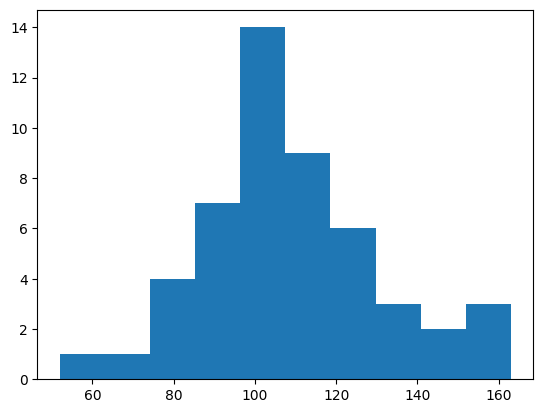

In [42]:
plt.hist(lengths_kg)
plt.show()

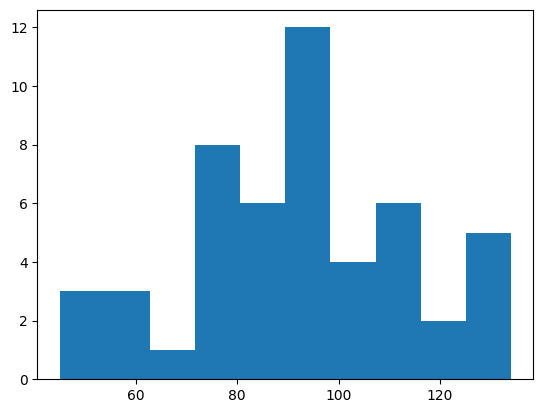

In [27]:
plt.hist(lengths_1_hop)
plt.show()

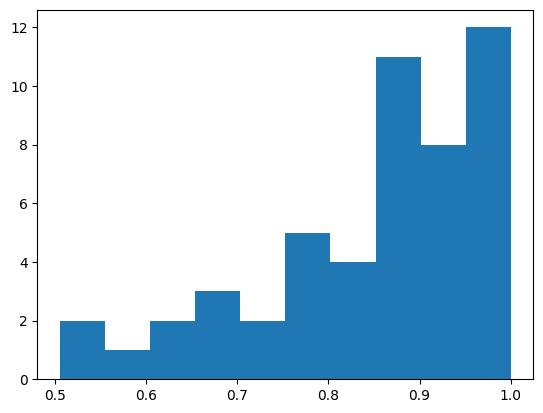

In [28]:
plt.hist(props_1_hop)
plt.show()

## 2-hop

In [29]:
retrieved_triplets = {}

for file in os.listdir('hotpot200_res'):
    df = pd.read_csv('hotpot200_res/{}'.format(file), index_col=0)
    idx = int(file.split('.')[0])

    unique_top_entities = id2unique_top_entities[idx]
    unique_top_entities = list(set(unique_top_entities))

    triplets = df[(df['subject'].apply(lambda x: x in unique_top_entities)) | (df['object'].apply(lambda x: x in unique_top_entities))]
    one_hop_entities = list(triplets['subject']) + list(triplets['object'])
    one_hop_entities = set(one_hop_entities) - set(unique_top_entities)
    one_hop_triplets = df[(df['subject'].apply(lambda x: x in one_hop_entities)) | (df['object'].apply(lambda x: x in one_hop_entities))]

    two_hop_entities = list(one_hop_triplets['subject']) + list(one_hop_triplets['object'])

    two_hop_entities = set(two_hop_entities) - set(one_hop_entities) - set(unique_top_entities)
    two_hop_triplets = df[(df['subject'].apply(lambda x: x in two_hop_entities)) | (df['object'].apply(lambda x: x in two_hop_entities))]

    triplets = pd.concat((triplets, one_hop_triplets, two_hop_triplets))

    triplets = triplets.to_records(index=False)

    retrieved_triplets[idx] = triplets


In [30]:
contain_ans = 0
sample_cnt = 0

for i, sample in retrieved_triplets.items():
    df = pd.DataFrame(sample)

    df['subject'] = df['subject'].apply(lambda x: normalize(x))
    df['object'] = df['object'].apply(lambda x: normalize(x))

    ans = normalize(ds[i]['answer'])

    if ans == "yes" or ans == "no":
        continue

    if len(df[(df['subject'] == ans) | (df['object'] == ans)]) > 0:
        contain_ans += 1

    else:
        print(ans)
    sample_cnt += 1

contain_ans / sample_cnt

fortnightly women interest magazine
a failed coup attempt
2 march 1972
pulitzer prize
hawaii county
german
superregional shopping mall
1978
london
chronological collection of critical quotations
22 november
1927
read it and weep 2006
velvetpark
papa ginos
shukratara
captain hans geering
frederick alexander


0.6170212765957447

In [32]:
contain_ans = 0
sample_cnt = 0
f1s = []

for i, sample in retrieved_triplets.items():
    df = pd.DataFrame(sample)

    df['subject'] = df['subject'].apply(lambda x: normalize(x))
    df['object'] = df['object'].apply(lambda x: normalize(x))
    
    ans = normalize(ds[i]['answer'])
    subj_obj = list(df['subject']) + list(df['object'])

    if ans == "yes" or ans == "no":
        continue

    if any([ans in elem for elem in subj_obj]) or any([elem in ans for elem in subj_obj]):
        contain_ans += 1

        # for elem in subj_obj:
        #     if ans in elem or elem in ans:
        #         print(f"Entity <{elem}> contains answer <{ans}>")
        #         break
        
    else:
        print("Does not contain ", ans)

    max_f1 = 0
    max_f1_entity = ''
    
    for elem in subj_obj:
        f1 = compute_f1(elem, ans)
        if f1 > max_f1:
            max_f1 = f1
            max_f1_entity = elem
    f1s.append(max_f1)
  
    sample_cnt += 1

contain_ans / sample_cnt, sum(f1s)/len(f1s)

Does not contain  a failed coup attempt
Does not contain  german
Does not contain  london
Does not contain  chronological collection of critical quotations
Does not contain  captain hans geering


(0.8936170212765957, 0.7745862884160757)

In [40]:
lengths_2_hop = []
props_2_hop = []

for i, sample in retrieved_triplets.items():
    df = pd.DataFrame(sample)
    df = df.drop_duplicates()
    lengths_2_hop.append(len(df))

    reference_kg = pd.read_csv(f'hotpot200_res/{i}.csv', index_col=0)
    props_2_hop.append(len(df)/len(reference_kg))


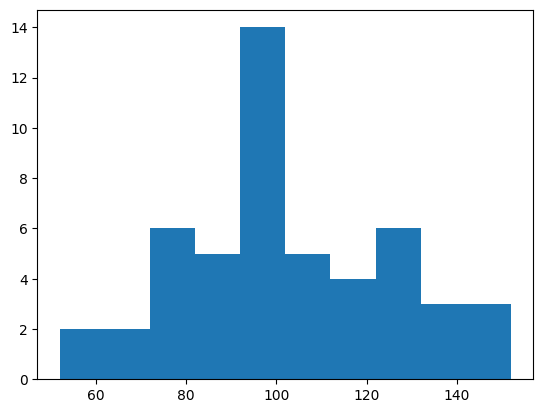

In [41]:
plt.hist(lengths_2_hop)
plt.show()

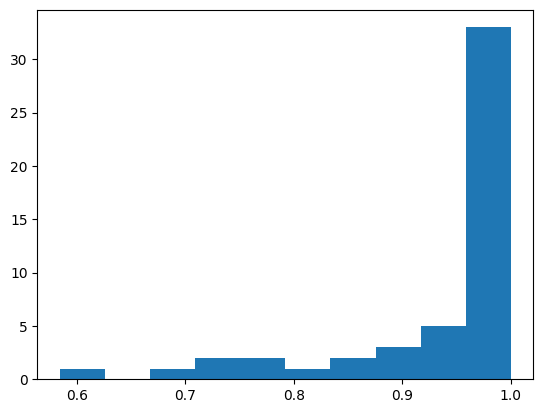

In [42]:
plt.hist(props_2_hop)
plt.show()